In [1]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa import  predict


BASE_DIR = "/home/ec2-user/outputs/2023-03-11/21-33-46" # /home/ec2-user/ or /Users/nsofroniew/Documents/data/rosa/
# BASE_DIR = "/home/ec2-user/outputs/2023-03-10/16-43-07" # /home/ec2-user/ or /Users/nsofroniew/Documents/data/rosa/
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    # chkpts = BASE_DIR + "/checkpoints/epoch=*.ckpt"
    chkpts = BASE_DIR + "/checkpoints/last.ckpt"
    chkpt = glob(chkpts)[0]

    adata, rdm, rlm = predict(config, chkpt)

# display(adata)
predicted = adata.layers['predicted']
measured = adata.layers['measured']
confidence = adata.layers['confidence']
print(chkpt)

Global seed set to 0
/tmp/ipykernel_82357/2153050671.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RosaLightningModule(
  (model): RosaFormerModel(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (input_embed_0): MaskedEmbed(
              (model): Sequential(
                (projection): Embedding(9, 64)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
          (1): Sequential(
            (layer_norm_1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=64, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): AddEmbeds()
      (transformer): Identity()
      (dropout): Dropout(p=0, inplace=False)
      (expression_head): ProjectionExp

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

/home/ec2-user/outputs/2023-03-11/21-33-46/checkpoints/last.ckpt


In [2]:
measured.shape

(369, 19431)

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
cm = confusion_matrix(measured.flatten(), predicted.flatten())

In [5]:
import matplotlib.pyplot as plt

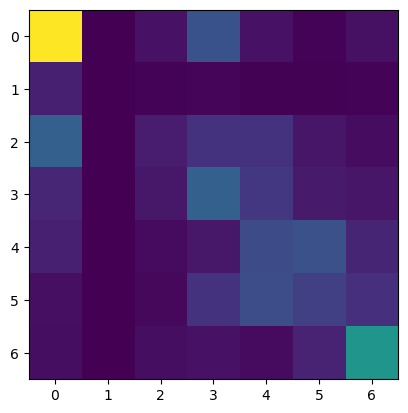

In [6]:
plt.imshow(cm);

In [7]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())



        mean spearmanr across genes 0.564
        mean spearmanr across cells nan
        mean square error 6.554
        ks-statistic on total expression 0.124
        mean percent total expression captured per cell 111.696
        


/home/ec2-user/rosa/rosa/utils/score.py:41: RuntimeWarning: Mean of empty slice
  results["spearmanr_across_cells_mean"] = np.nanmean(


/opt/conda/envs/pytorch/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/opt/conda/envs/pytorch/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


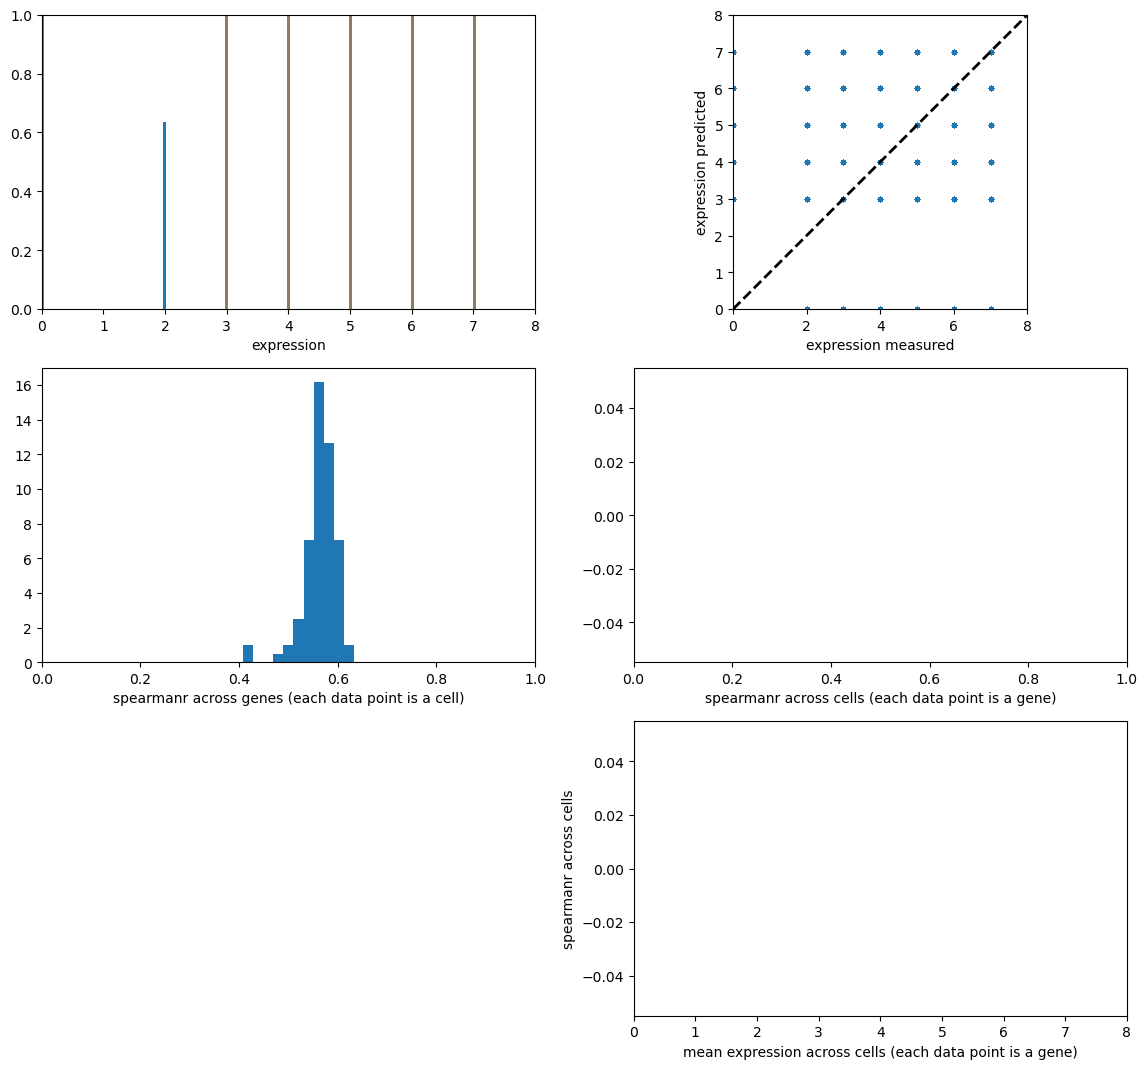

In [8]:
if config.data_module.data.expression_transform.n_bins is not None:
    max_expression_val = config.data_module.data.expression_transform.n_bins
else:
    max_expression_val = 6
    
plot_expression_and_correlation(adata_test, results, max_expression_val=max_expression_val)

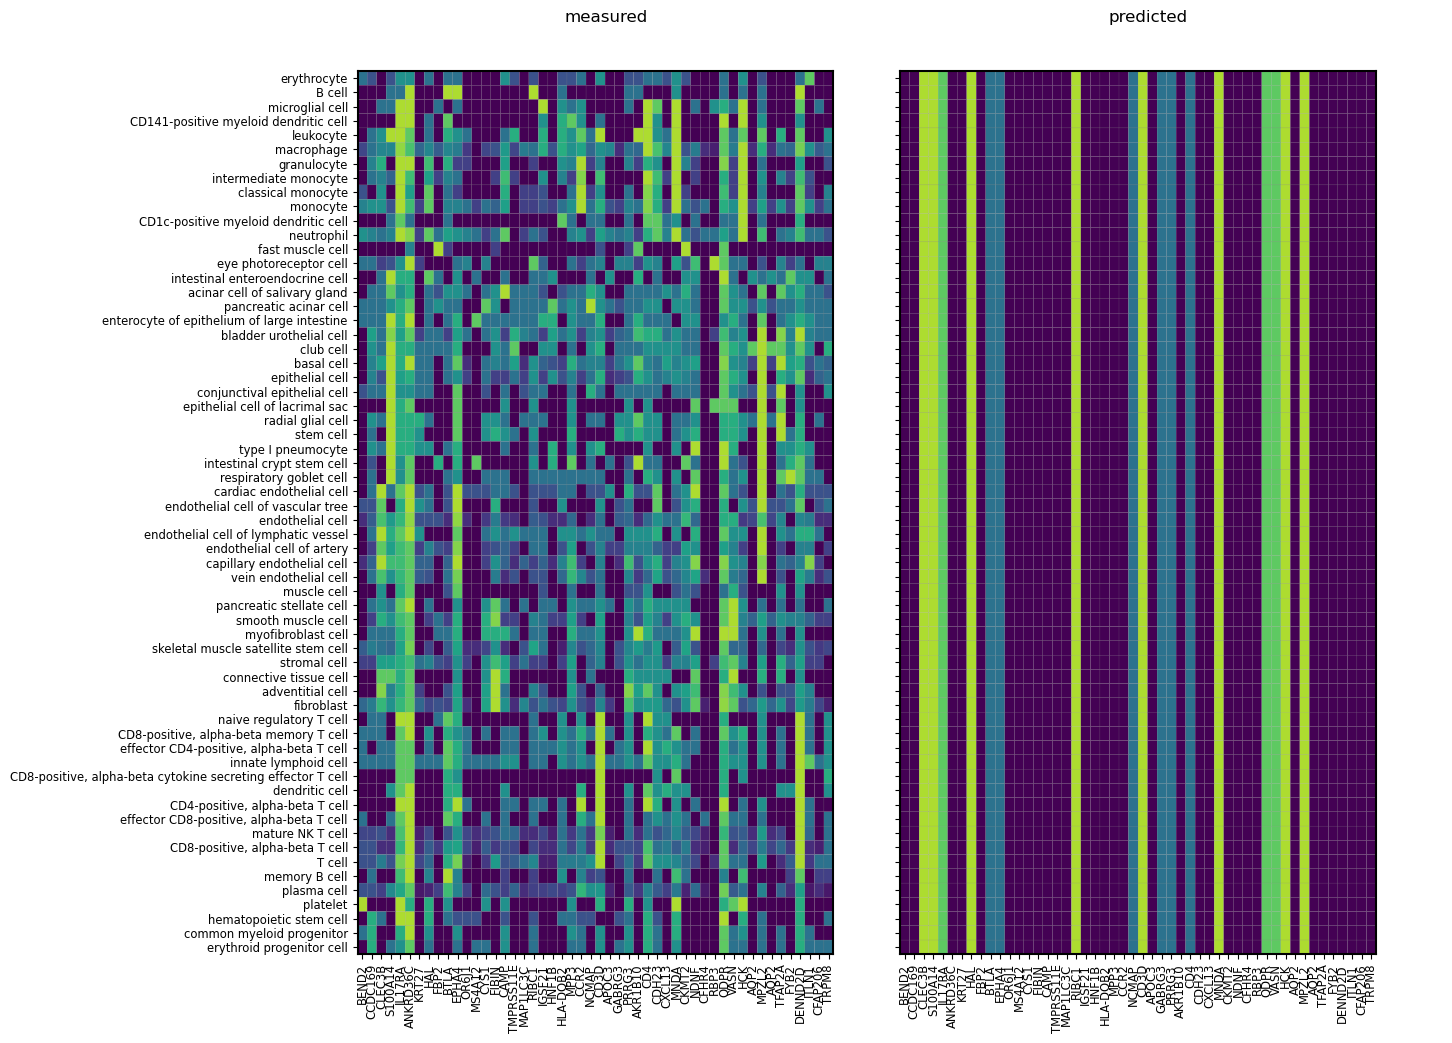

In [9]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes, max_expression_val=max_expression_val)

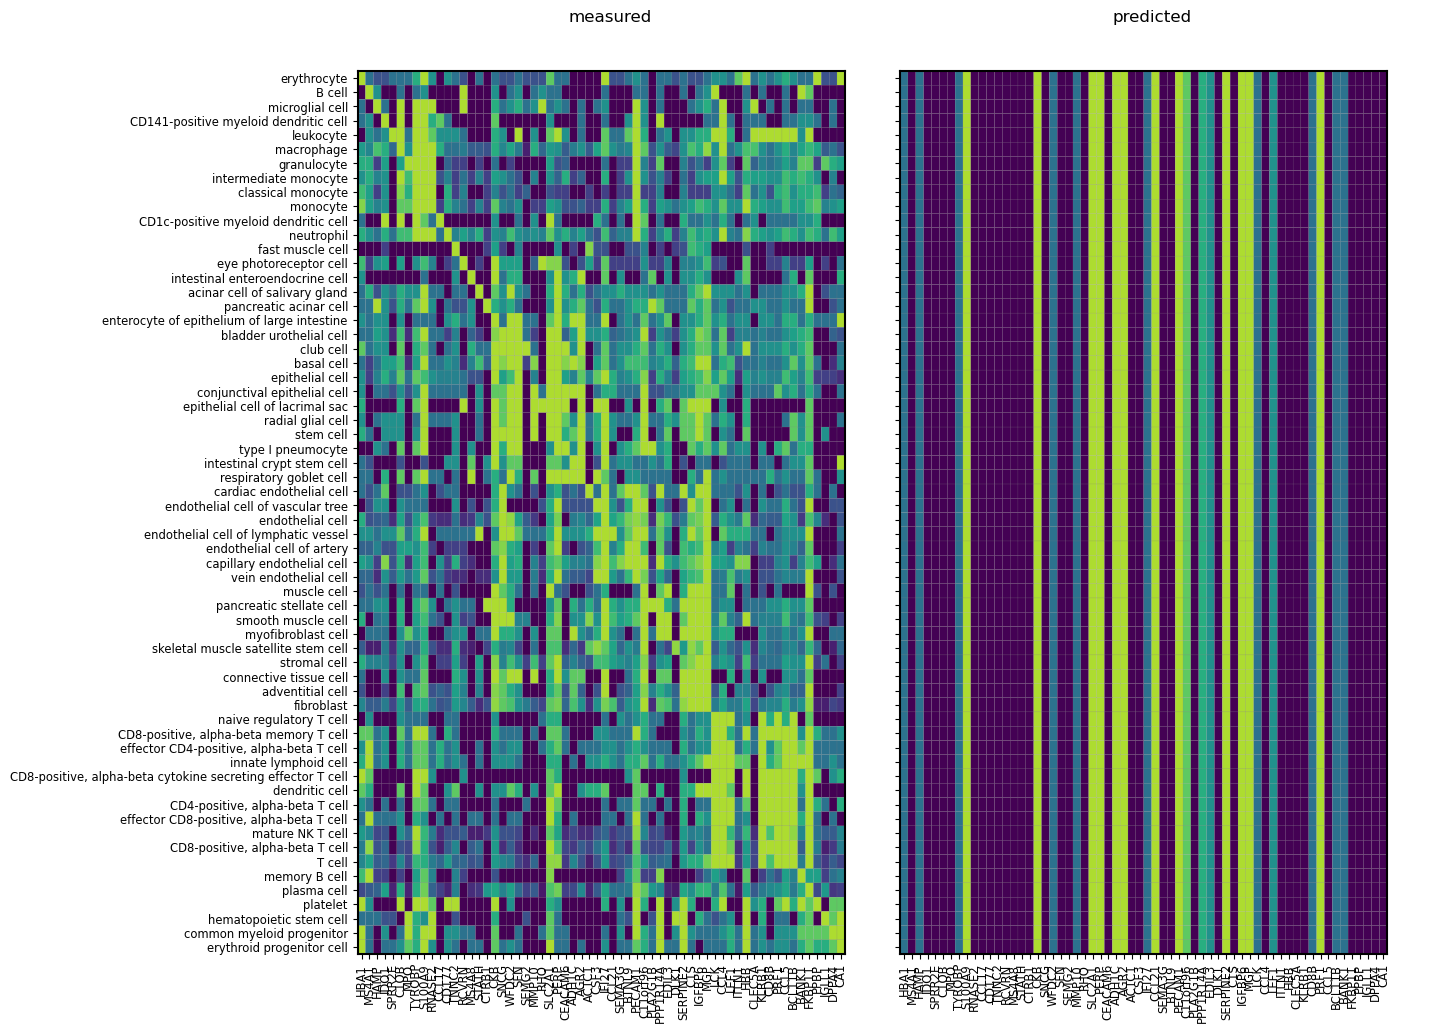

In [10]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict, max_expression_val=max_expression_val)

In [11]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage
import sys


sys.setrecursionlimit(100000)

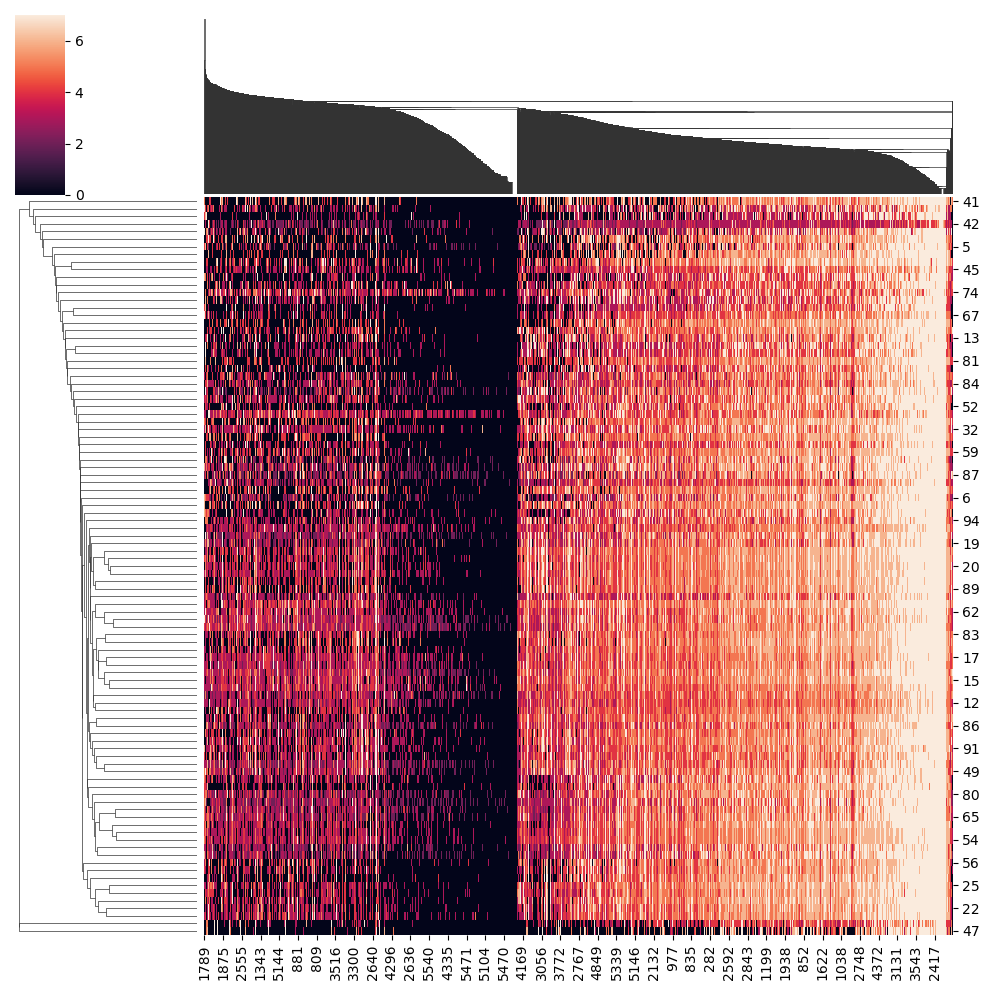

In [12]:
D = adata_test.layers['measured']

row_linkage = linkage(D) # D being the measurement
col_linkage = linkage(D.T) # D being the measurement
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)

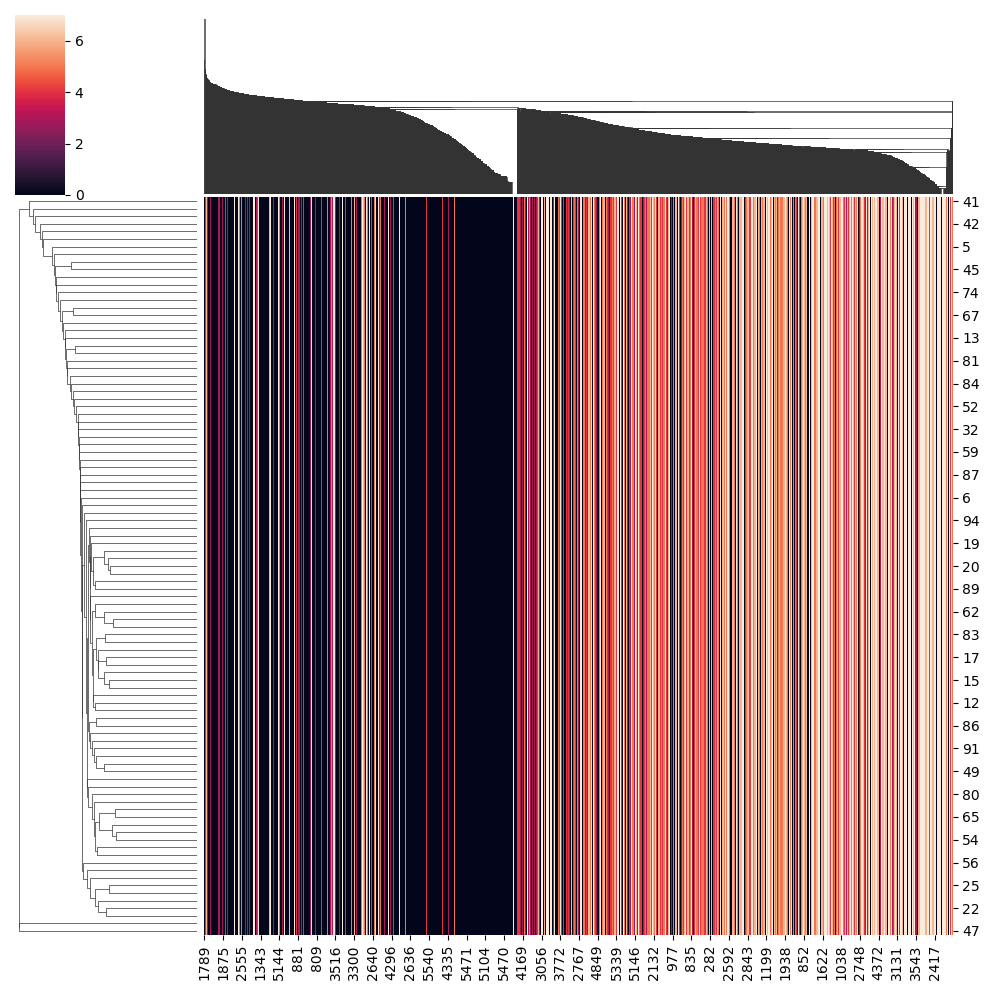

In [13]:
D = adata_test.layers['predicted']
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)

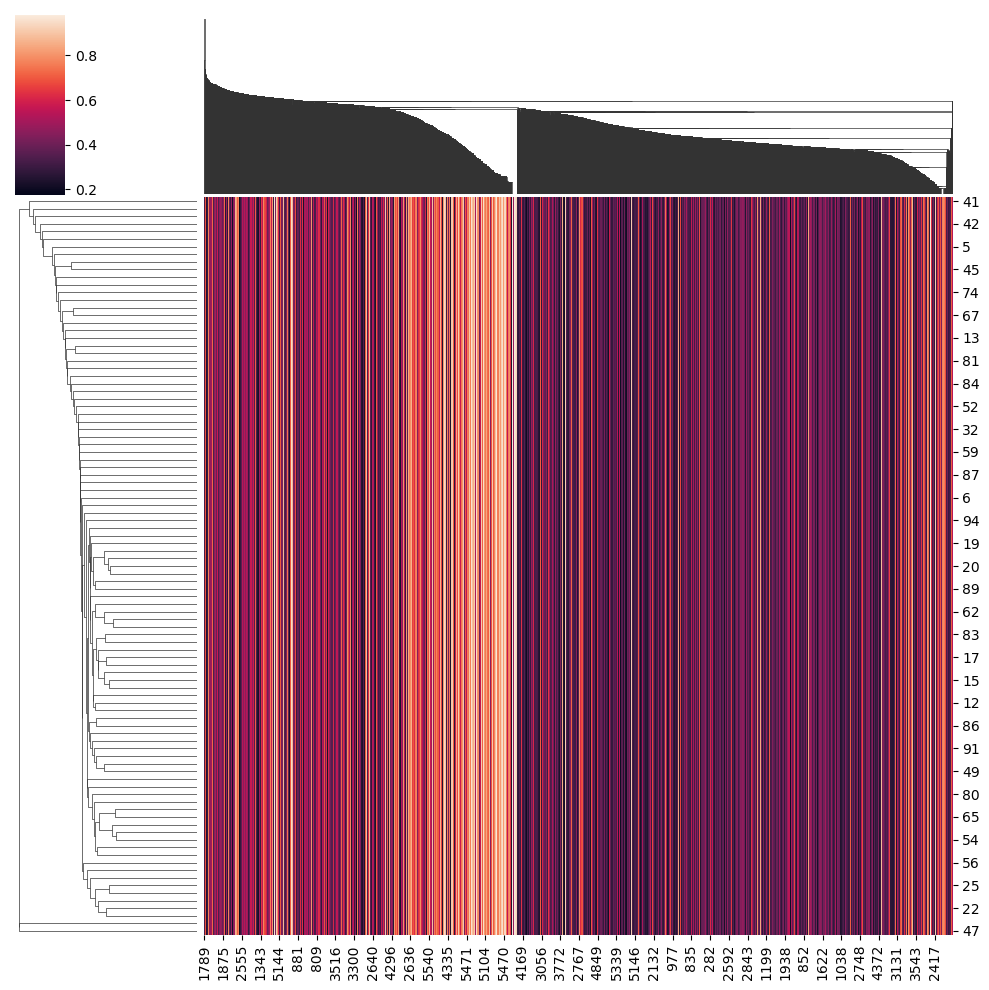

In [14]:
D = adata_test.layers['confidence']
sns.clustermap(D, row_linkage=row_linkage, col_linkage=col_linkage)